In [1]:
using Plots,Polynomials,SpecialPolynomials,LinearAlgebra,CSV,DataFrames, Colors

#### Zadanie 1

Funkcja `hermite_poly(n)` przyjmuje numer wielomianu Hermite’a `n` i zwraca obiekt typu `Polynomial` \( H_n(x) \) 

Dla n = 0,1 funkcja zwraca gotowy wielomian, dla większych n oblicza kolejne ze wzoru:

$ H_n(x) = x \cdot H_{n-1}(x) - (n - 1) \cdot H_{n-2}(x) $

In [2]:
function hermite_poly(n)
    H_prevprev = Polynomial([1.0])       # wielomian f(x) = 1 (zerowy hermita)
    H_prev = Polynomial([0.0, 2.0])       # wielomian f(x) = 2x (pierwszy hermita)
    
    if n == 0
        return H_prevprev
    elseif n == 1
        return H_prev
    else
        x_poly = Polynomial([0.0, 1.0])       # wielomian f(x) = x

        for m in 2:n
            H_curr = x_poly * H_prev - (m - 1) * H_prevprev
            H_prevprev, H_prev = H_prev, H_curr
        end

        return H_prev
    end
end
nothing

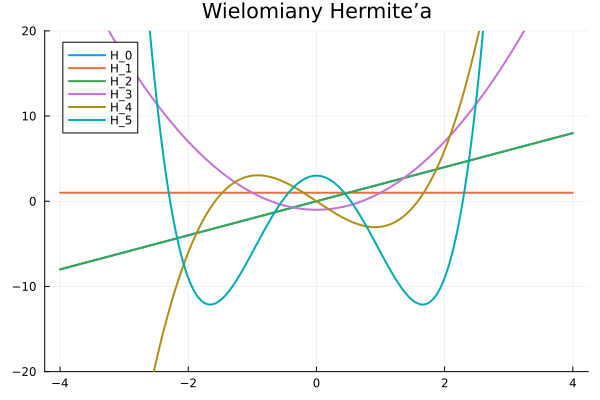

In [3]:
x = -4:0.01:4
plt = plot(ylims=[-20,20], title="Wielomiany Hermite’a", legend=:topleft)

for n in 0:5
    Hn = hermite_poly(n-1)
    y = Hn.(x)
    plot!(plt, x, y, label="H_$n",lw=2)
end

display(plt)


6 pierwszych funkcji bazowych z uwzględnieniem czynnika wagowego $H_m(x)\exp(-\frac{x^2}{2})$

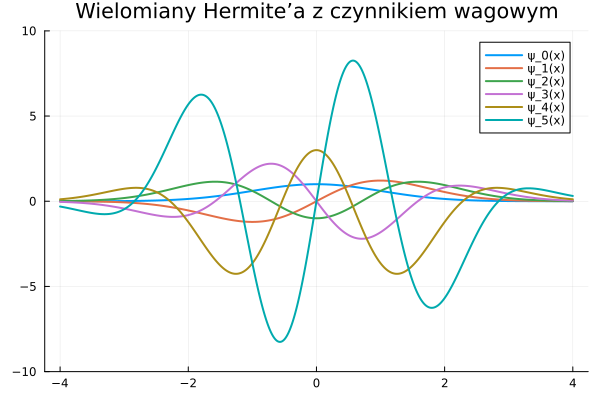

In [4]:
x = -4:0.01:4

plt = plot(ylims=[-10, 10], title="Wielomiany Hermite’a z czynnikiem wagowym", legend=:topright)

for n in 0:5
    Hn = hermite_poly(n)
    y = Hn.(x) .* exp.(-0.5 .* x.^2)
    plot!(plt, x, y, label="ψ_$n(x)", lw=2)
end

display(plt)

#### Zadanie 2

In [ ]:
function hermite_basis_function(k, x, normalize_result=true)
    weighted_vals = basis(Hermite, k).(x) .* exp.(-(x.^2) ./ 2)
    return normalize_result ? normalize(weighted_vals) : weighted_vals
end

hermite_basis_function (generic function with 2 methods)

In [ ]:
x_vals = -5:0.1:5

hermite_polynomials = [basis(Hermite, k) for k in 0:5]
poly_vals = [p.(x_vals) for p in hermite_polynomials]

basis_functions = [hermite_basis_function(k, x_vals) for k in 0:5]

scalar_prods_no_weight = Matrix{Float64}(undef, 6, 6)
scalar_prods_with_weight = Matrix{Float64}(undef, 6, 6)

for (i, vec_i) in enumerate(poly_vals)
    for (j, vec_j) in enumerate(poly_vals)
        scalar_prods_no_weight[i, j] = dot(vec_i, vec_j)
    end
end

for (i, vec_i) in enumerate(basis_functions)
    for (j, vec_j) in enumerate(basis_functions)
        scalar_prods_with_weight[i, j] = dot(vec_i, vec_j)
    end
end

scalar_prods_no_weight


6×6 Matrix{Float64}:
  101.0             3.55271e-15  3232.0          …  1.70137e5     4.36557e-11
    3.55271e-15  3434.0             1.13687e-13     2.91038e-11   1.13091e7
 3232.0             1.13687e-13     1.96801e5       1.2485e7     -2.79397e-9
   -4.54747e-13     1.89529e5       0.0             1.86265e-9    8.52416e8
    1.70137e5       2.91038e-11     1.2485e7        8.80768e8     1.19209e-7
    4.36557e-11     1.13091e7      -2.79397e-9   …  1.19209e-7    6.01582e10

In [7]:
scalar_prods_with_weight

6×6 Matrix{Float64}:
  1.0           1.17804e-17  -3.25356e-11  …  -4.52405e-10   2.83568e-17
  1.17804e-17   1.0           8.46587e-18     -1.2455e-19   -9.92118e-9
 -3.25356e-11   8.46587e-18   1.0             -1.67261e-8   -1.7485e-18
  1.85612e-18  -9.61163e-10  -7.22228e-18     -2.57256e-18  -2.04018e-7
 -4.52405e-10  -1.2455e-19   -1.67261e-8       1.0           2.68944e-17
  2.83568e-17  -9.92118e-9   -1.7485e-18   …   2.68944e-17   1.0

Widać, że wektory są znormalizowane (wartości 1 na przekątnej) oraz wzajemnie ortogonalne (dla  i != j wartości bliskie zeru).  
Zatem tworzą one bazę ortonormalną.


#### Zadanie 3

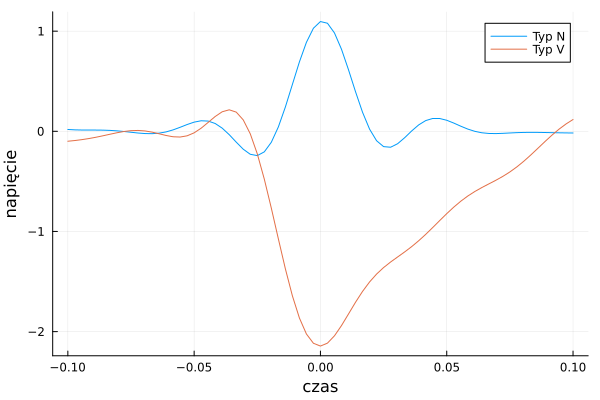

In [8]:
ekg_data = CSV.read("ecg_data.csv", DataFrame)
plot(ekg_data.time, ekg_data.signalN, label="Typ N", xlabel = "czas", ylabel="napięcie")
plot!(ekg_data.time, ekg_data.signalV, label="Typ V")

Gradient kolejnych aproksymacji

In [9]:
function gradient_color(i, total)
    alpha = i / (total - 1)
    return RGB(alpha, 1 - alpha, alpha)
end

gradient_color (generic function with 1 method)

In [10]:
xx_ekg = ekg_data.time .* 40

max_k = 5

ys = [hermite_basis_function(k, xx_ekg) for k in 0:max_k-1]
colors = [gradient_color(i, max_k) for i in 0:max_k-1]
nothing

Aproksymacja sygnału V

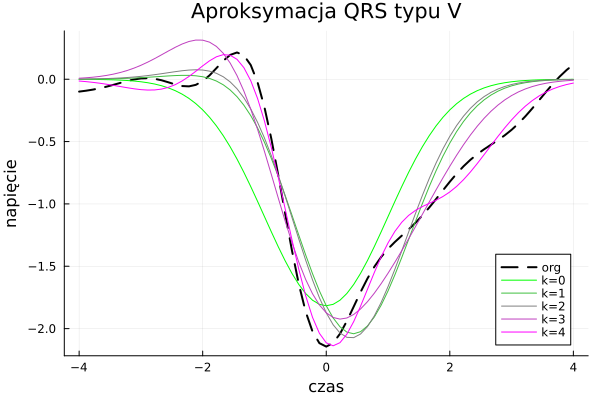

In [11]:
yy_ekgV = ekg_data.signalV

cs = [dot(yy_ekgV, y) for y in ys]
Vs = [c * y for (c, y) in zip(cs, ys)]
partial_sums = cumsum(Vs)


plot(
    xx_ekg, yy_ekgV,
    label="org",
    linewidth=2,
    linestyle=:dash,
    color=:black,
    xlabel="czas", ylabel="napięcie",
    title="Aproksymacja QRS typu V"
)

for (i, vsum) in enumerate(partial_sums)
    plot!(xx_ekg, vsum,
        label="k=$(i-1)",
        linewidth=1,
        color=colors[i]
    )
end

display(plot!())


Aproksymacja sygnału N

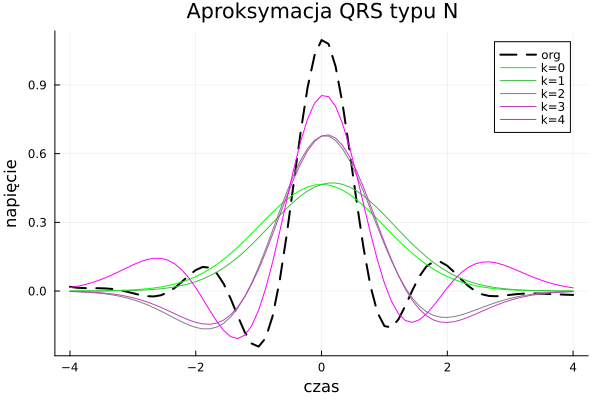

In [12]:
yy_ekgN = ekg_data.signalN

cs = [dot(yy_ekgN, y) for y in ys]
Vs = [c * y for (c, y) in zip(cs, ys)]
partial_sums = cumsum(Vs)


plot(
    xx_ekg, yy_ekgN,
    label="org",
    linewidth=2,
    linestyle=:dash,
    color=:black,
    xlabel="czas", ylabel="napięcie",
    title="Aproksymacja QRS typu N"
)

# Aproksymacje
for (i, approx) in enumerate(partial_sums)
    plot!(xx_ekg, approx,
        label="k=$(i-1)",
        linewidth=1,
        color=colors[i]
    )
end

display(plot!())


#### Zadanie 4

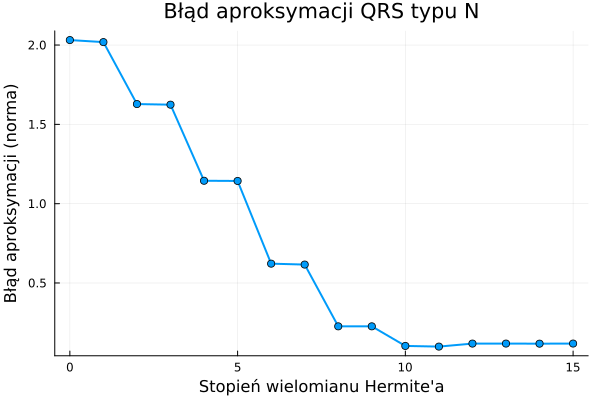

In [13]:
using Plots

xx_ekg = ekg_data.time .* 40
yy_ekgN = ekg_data.signalN

# Maksymalny stopień
max_k = 15
errors = Float64[]

# Liczenie błędów
for k in 0:max_k
    hermite_functions = [hermite_basis_function(i, xx_ekg) for i in 0:k]
    dot_prods = [dot(yy_ekgN, y) for y in hermite_functions]
    Vs = [c * y for (c, y) in zip(dot_prods, hermite_functions)]
    approx = sum(Vs)
    err = norm(yy_ekgN - approx)
    push!(errors, err)
end


# Wykres błędu
plot(
    0:max_k, errors,
    marker=:circle,
    xlabel="Stopień wielomianu Hermite'a",
    ylabel="Błąd aproksymacji (norma)",
    title="Błąd aproksymacji QRS typu N",
    legend=false,
    linewidth=2
)


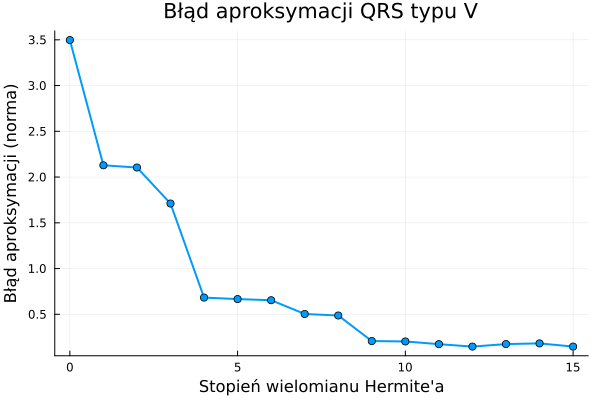

In [14]:
using Plots

xx_ekg = ekg_data.time .* 40
yy_ekgV = ekg_data.signalV

# Maksymalny stopień
max_k = 15
errors = Float64[]

# Liczenie błędów
for k in 0:max_k
    hermite_functions = [hermite_basis_function(i, xx_ekg) for i in 0:k]
    dot_prods = [dot(yy_ekgV, y) for y in hermite_functions]
    Vs = [c * y for (c, y) in zip(dot_prods, hermite_functions)]
    approx = sum(Vs)
    err = norm(yy_ekgV - approx)
    push!(errors, err)
end


# Wykres błędu
plot(
    0:max_k, errors,
    marker=:circle,
    xlabel="Stopień wielomianu Hermite'a",
    ylabel="Błąd aproksymacji (norma)",
    title="Błąd aproksymacji QRS typu V",
    legend=false,
    linewidth=2
)
